In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [8]:
class Particula:

    """
    Clase que representa una partícula en el grafo.
    Atributos:
    - posicion (int): La posición actual de la partícula.
    - bloqueado (bool): Indica si la partícula está bloqueada o no (si puede avanzar o no).
    Métodos:
    - __init__(posicion: int, bloqueado: bool): Inicializa una nueva instancia de la clase Particula.
    - avanzar(): Avanza la partícula una posición hacia adelante.
    - __str__(): Devuelve una representación en cadena de la partícula como str.
    """

    def __init__(self, calle, posicion: int, bloqueado: bool = False, id: int=0) -> None:
        self.calle = calle
        self.posicion = posicion
        self.bloqueado = bloqueado
        self.id = id
        
    def avanzar(self) -> None:
        self.posicion += 1

    def __str__(self) -> str:
        return f'Posición: {self.posicion}, Bloqueado: {self.bloqueado}'

In [9]:
class Interseccion():

    """
    Clase que representa una intersección en un sistema de tráfico.
    Atributos:
    posicion : tupla, coordenadas de la intersección.
    bloqueado : list, indica si la intersección está bloqueada en ciertas direcciones.
    calles : tuple, contiene las calles conectadas a la intersección.

    Métodos:
    __str__() -> str: Devuelve una representación en cadena de la intersección.
    update_bloqueo(direccion): Actualiza el estado de bloqueo de la calle en la dirección especificada.
    """
        
    def __init__(self, posicion: tuple, bloqueado: list, calles: tuple) -> None:
        self.posicion = posicion
        self.bloqueado = bloqueado
        self.calles = calles

    def __str__(self) -> str:
        return f'Posición: {self.posicion}, Bloqueado: {self.bloqueado}'

    def update_bloqueo(self, direccion):
        self.calles[direccion].update_bloqueo()

In [10]:
class Calle(list):

    """
    Clase que representa una calle en un modelo de simulación TASEP.
    Métodos:
    - __init__(*args): Constructor de la clase.
    - agregar_particula_inicio(): Agrega una partícula al inicio de la calle.
    - update_bloqueo_casilla(i: int): Actualiza el estado de bloqueo de una casilla en la calle.
    - update_bloqueo(): Actualiza el estado de bloqueo de todas las casillas en la calle.
    - update_secuencial(p: float): Actualiza la posición de las partículas en la calle de forma secuencial.
    - update_paralelo(p: float): Actualiza la posición de las partículas en la calle de forma paralela.
    - plot(): Grafica la posición de las partículas en la calle.
    - animate(n: int, p: float, mode: str): Genera una animación de la simulación.
    - __str__(): Retorna una representación en cadena de la calle.
    """

    def __init__(self, *args, direccion: int, intersecciones: list, posicion: int) -> None:
        super().__init__(*args)
        self.direccion = direccion
        self.intersecciones = intersecciones
        self.posicion = posicion
        self.altura = None
        self.inv = None

    
    def inversa(self,u):
            for i in range(1, len(self)+1):
                if self[-i].posicion<=u:
                    return i-1


    def iniciar_altura(self, Min, Max) -> None:
        inv=self.inversa(-1)
        dict={}
        
        for u in range(Min, Max+1):
            dict[u]=2*(self.inversa(u-1)-inv)+u
        self.altura=dict
        self.inv=inv
    
    def actualizar_altura(self) -> None:
        Min=list(self.altura.keys())[0]
        Max=list(self.altura.keys())[-1]
        dict={}

        for u in range(Min, Max+1):
            dict[u]=2*(self.inversa(u-1)-self.inv)+u
        self.altura=dict              


    def agregar_particula_inicio(self, id: int = 0, p: float = 1) -> None:
        nueva_particula = Particula(self, 0, False, id)
        if len(self) == 0:
            self.append(nueva_particula)
            self.update_estado_intersecciones()
            return nueva_particula
        elif self[0].posicion != 0 and np.random.rand() < p:
            self.insert(0, nueva_particula)
            self.update_bloqueo()
            self.update_estado_intersecciones()
            return nueva_particula

    def agregar_interseccion(self, interseccion: Interseccion) -> None:
        self.intersecciones.append(interseccion)

    def delete_particulas_posicion(self, posicion: int) -> None:
        for i, p in enumerate(self):
            if p.posicion > posicion:
                break

    def update_estado_intersecciones(self) -> None:
        for interseccion in self.intersecciones:
            bloqueado = False
            for particula in self:
                if particula.posicion == interseccion.posicion[(self.direccion + 1) % 2]:
                    bloqueado = True
                    # La particula esta en la interseccion, bloquea el paso en la otra direccion
                    interseccion.bloqueado[(self.direccion + 1) % 2] = True
                    break
            # Ninguna particula de esta direccion esta en la interseccion, desbloquea el paso en la otra direccion
            if not bloqueado:
                interseccion.bloqueado[(self.direccion + 1) % 2] = False
            

    def update_bloqueo_casilla(self, i: int) -> None:
        # La de mas adelante no esta bloqueada (excepto por el if de abajo)
        if i == len(self) - 1:
            self[i].bloqueado = False
        else:
            self[i].bloqueado = self[i+1].posicion == self[i].posicion + 1
        # Si la particula no esta bloqueada en su calle, revisar si la interseccion la bloquea
        if not self[i].bloqueado:
            for interseccion in self.intersecciones:
                # Si la siguiente posicion de la particula es la posicion de la interseccion en la direccion de la calle
                # entonces la interseccion bloquea la particula
                if (self[i].posicion +1) == interseccion.posicion[(self.direccion + 1) % 2]:
                    self[i].bloqueado = interseccion.bloqueado[self.direccion]
                    break
    
    
    # Buena
    def update_secuencial(self, p: float) -> None:
        for i in range(len(self)-1, -1, -1):
            if not self[i].bloqueado and np.random.rand() < p:
                self[i].avanzar()
                # Verificar si se bloquea la casilla luego de avanzar
                self.update_bloqueo_casilla(i)
                # Verificar si se desbloquea la casilla anterior luego de avanzar (si no es la última casilla)
                if i != 0:
                    self.update_bloqueo_casilla(i-1)
        # Actualizar el estado de las intersecciones para las que se usen en las siguientes calles
        self.update_estado_intersecciones()
    
    def update_bloqueo(self) -> None:
        for i in range(len(self)):
            self.update_bloqueo_casilla(i)    

    def update_paralelo(self, p: float) -> None:
        for i in range(len(self)-1, -1, -1):
            if not self[i].bloqueado:
                if np.random.rand() < p:
                    self[i].avanzar()
        # Los bloqueos se actualizan al final de la iteracion
        self.update_bloqueo()
        # Actualizar el estado de las intersecciones para las que se usen en las siguientes calles
        self.update_estado_intersecciones()

    def __str__(self) -> str:
        return '\n'.join([str(p) for p in self])

    def agregar_densidad(self, cantidad: int, step: int) -> None:
        for i in range(cantidad):
            posicion = -i * step
            nueva_particula = Particula(self, posicion, False, i)
            self.insert(0, nueva_particula)
        self.update_bloqueo()
        self.update_estado_intersecciones()

In [11]:
class Calles():

    def __init__(self, calles: list) -> None:
        self.calles = calles
        self.calles_x = [c for c in calles if c.direccion == 0]
        self.calles_y = [c for c in calles if c.direccion == 1]
        self.intersecciones = []

    def update_intersecciones(self) -> None:
        for calle_x in self.calles_x:
            for calle_y in self.calles_y:
                choque_x = False
                choque_y = False
                for particula in calle_x:
                    if particula.posicion == calle_y.posicion:
                        choque_x = True
                        break
                for particula in calle_y:
                    if particula.posicion == calle_x.posicion:
                        choque_y = True
                        break
                if choque_x and choque_y:
                    raise ValueError('Hay un choque')         
                interseccion = Interseccion((calle_x.posicion, calle_y.posicion), [choque_x, choque_y], (calle_x, calle_y))
                calle_x.agregar_interseccion(interseccion)
                calle_y.agregar_interseccion(interseccion)
                self.intersecciones.append(interseccion)

    def update_bloqueos(self) -> None:
        for calle in self.calles:
            calle.update_bloqueo()

    def update_estado_intersecciones(self) -> None:
        for calle in self.calles:
            calle.update_estado_intersecciones()

    def update_secuencial(self, p: float) -> None:
        for calle in self.calles:
            # Actualiza una calle
            calle.update_secuencial(p)
            # Después de actualizar una calle es necesario actualizar los bloqueos de todas las calles
            self.update_bloqueos()

    def update_paralelo(self, p: float) -> None:
        # Definir un orden para iterar (de manera uniforme para simular paralelismo)
        calles_copy = self.calles.copy()
        random.shuffle(calles_copy)
        # for bajo ese orden
        for calle in calles_copy:
            # Actualiza una calle
            calle.update_paralelo(p)
        # Después de actualizar todas las calles es necesario actualizar los bloqueos de todas las calles
            self.update_bloqueos()

    def plot(self) -> None:
        for calle in self.calles:
            calle.plot()

    def plot_2d(self) -> None:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xlim(0, 20)
        ax.set_ylim(0, 20)
        ax.grid(True)  # Agregar grilla
        
        colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k']  # Lista de colores para las calles
        color_index = 0
        
        for interseccion in self.intersecciones:
            ax.plot(interseccion.posicion[1], interseccion.posicion[0], 'ko')
        
        for calle in self.calles_x:
            color = colors[color_index % len(colors)]
            ax.plot([p.posicion for p in calle], [calle.posicion for _ in calle], color + 'o', label=f'Calle X {calle.posicion}')
            color_index += 1
        
        for calle in self.calles_y:
            color = colors[color_index % len(colors)]
            ax.plot([calle.posicion for _ in calle], [p.posicion for p in calle], color + 'o', label=f'Calle Y {calle.posicion}')
            color_index += 1
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        plt.show()

    def delete_particulas_posicion(self, posicion: int) -> None:
        for calle in self.calles:
            calle.delete_particulas_posicion(posicion)

    def add_calle(self, calle) -> None:
        self.calles.append(calle)
        if calle.direccion == 0:
            self.calles_x.append(calle)
        else:
            self.calles_y.append(calle)

    def agregar_particulas_inicio(self, initial_id: int = 0, p: float = 1) -> list:
        particulas_agregadas = []
        for calle in self.calles:
            nueva_particula = calle.agregar_particula_inicio(initial_id, p)
            if nueva_particula is not None:
                particulas_agregadas.append(nueva_particula)
                initial_id += 1
        return particulas_agregadas

    def vaciar_objeto(self) -> None:
        self.calles = []
        self.calles_x = []
        self.calles_y = []
        self.intersecciones = []

    def get_particulas(self) -> list:
        particulas = []
        for calle in self.calles:
            particulas += calle
        return particulas

In [12]:
def setup_simulation(quantity, step_x, step_y):
    calle_x = Calle(direccion=0, intersecciones=[], posicion=0)
    calle_y = Calle(direccion=1, intersecciones=[], posicion=0)

    calles = Calles(calles=[])
    calles.add_calle(calle_x)
    calles.add_calle(calle_y)

    calles.update_intersecciones()

    calle_x.agregar_densidad(cantidad=quantity, step=step_x)
    calle_y.agregar_densidad(cantidad=quantity, step=step_y)

    return calles, calle_x, calle_y


In [24]:
def run_simulation_exp(p, q, step_x, step_y, quantity):

    calles, calle_x, calle_y = setup_simulation(step_y=step_y, step_x=step_x, quantity=quantity)
    particulas_x = calle_x[::-1]
    particulas_y = calle_y[::-1]

    particula_x = particulas_x[0]
    num_particula_x = 0
    particula_y = particulas_y[0]
    num_particula_y = 0

    tiempo_x = 0
    tiempo_y = 0
    tiempos_x = []
    tiempos_y = []

    while num_particula_x < len(particulas_x) or num_particula_y < len(particulas_y):

            if particula_x.posicion >= -1 and num_particula_x < len(particulas_x):
                tiempo_x += 1
            if particula_y.posicion >= -1 and num_particula_y < len(particulas_y):
                tiempo_y += 1

            calle_x.update_secuencial(p)
            calle_y.update_secuencial(q)
            calles.update_bloqueos()
            calles.update_estado_intersecciones()

            if particula_x.posicion >= 0 and num_particula_x < len(particulas_x):
                tiempos_x.append(tiempo_x)
                tiempo_x = 0
                num_particula_x += 1
                if num_particula_x < len(particulas_x):
                    particula_x = particulas_x[num_particula_x]

            if particula_y.posicion >= 0 and num_particula_y < len(particulas_y):
                tiempos_y.append(tiempo_y)
                tiempo_y = 0
                num_particula_y += 1
                if num_particula_y < len(particulas_y):
                    particula_y = particulas_y[num_particula_y]

    tiempo_esperado_x = np.mean(tiempos_x) if tiempos_x else None
    tiempo_esperado_y = np.mean(tiempos_y) if tiempos_y else None

    return tiempo_esperado_x, tiempo_esperado_y

In [25]:
def run_simulation_count(p, q, step_x, step_y, num_iterations):
    calles, calle_x, calle_y = setup_simulation(step_y=step_y, step_x=step_x, quantity=num_iterations)

    total_cruces_x = 0
    total_cruces_y = 0

    for _ in range(num_iterations):
        calle_x.update_secuencial(p)
        calle_y.update_secuencial(q)
        calles.update_bloqueos()
        calles.update_estado_intersecciones()

    cruces_x = [particula for particula in calle_x if particula.posicion >= 1]
    total_cruces_x += len(cruces_x)

    cruces_y = [particula for particula in calle_y if particula.posicion >= 1]
    total_cruces_y += len(cruces_y)

    tasa_cruces_x = total_cruces_x / num_iterations
    tasa_cruces_y = total_cruces_y / num_iterations

    return tasa_cruces_x, tasa_cruces_y

In [26]:
from IPython.display import clear_output

p_values = np.linspace(0.1, 1, 10)
q_values = np.linspace(0.1, 1, 10)

steps_x = np.linspace(1, 10, 10)
steps_y = np.linspace(1, 10, 10)

tiempos_esperados_x = np.zeros((len(p_values), len(q_values)))
tiempos_esperados_y = np.zeros((len(p_values), len(q_values)))

tiempos_esperados_x_steps = np.zeros((len(steps_x), len(steps_y)))
tiempos_esperados_y_steps = np.zeros((len(steps_x), len(steps_y)))

tasas_cruces_x = np.zeros((len(p_values), len(q_values)))
tasas_cruces_y = np.zeros((len(p_values), len(q_values)))

tasas_cruces_x_steps = np.zeros((len(steps_x), len(steps_y)))
tasas_cruces_y_steps = np.zeros((len(steps_x), len(steps_y)))

num_iterations = 200
quantity = 200

total_simulations = len(p_values) * len(q_values) + len(steps_x) * len(steps_y)
completed_simulations = 0

for i, p in enumerate(p_values):
    for j, q in enumerate(q_values):
        clear_output(wait=True)
        completed_simulations += 1
        percentage = (completed_simulations / total_simulations) * 100
        print(f"Simulando para p={p:.2f}, q={q:.2f} - {percentage:.2f}% completado")

        tiempo_x, tiempo_y = run_simulation_exp(p, q, step_x=1, step_y=1, quantity=quantity)
        tasa_x, tasa_y = run_simulation_count(p, q, step_x=1, step_y=1, num_iterations=num_iterations)

        tasas_cruces_x[i, j] = tasa_x
        tasas_cruces_y[i, j] = tasa_y

        tiempos_esperados_x[i, j] = tiempo_x
        tiempos_esperados_y[i, j] = tiempo_y

for i, step_x in enumerate(steps_x):
    for j, step_y in enumerate(steps_y):
        clear_output(wait=True)
        completed_simulations += 1
        percentage = (completed_simulations / total_simulations) * 100
        print(f"Simulando para step_x={step_x}, step_y={step_y} - {percentage:.2f}% completado")

        tiempo_x, tiempo_y = run_simulation_exp(p=0.5, q=0.5, step_x=step_x, step_y=step_y, quantity=quantity)
        tasa_x, tasa_y = run_simulation_count(p=0.5, q=0.5, step_x=step_x, step_y=step_y, num_iterations=num_iterations)

        tasas_cruces_x_steps[i, j] = tasa_x
        tasas_cruces_y_steps[i, j] = tasa_y

        tiempos_esperados_x_steps[i, j] = tiempo_x
        tiempos_esperados_y_steps[i, j] = tiempo_y


Simulando para step_x=10.0, step_y=10.0 - 100.00% completado


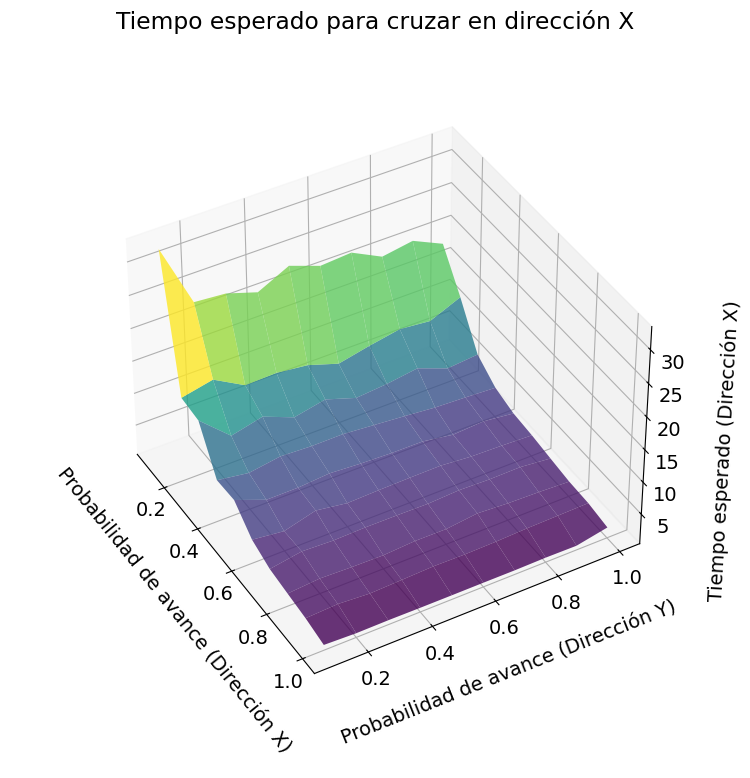

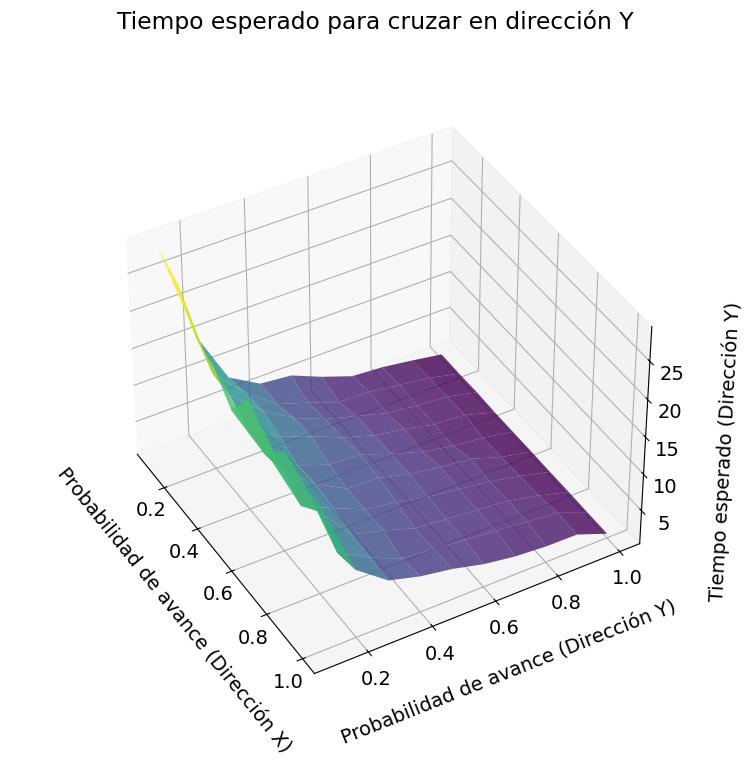

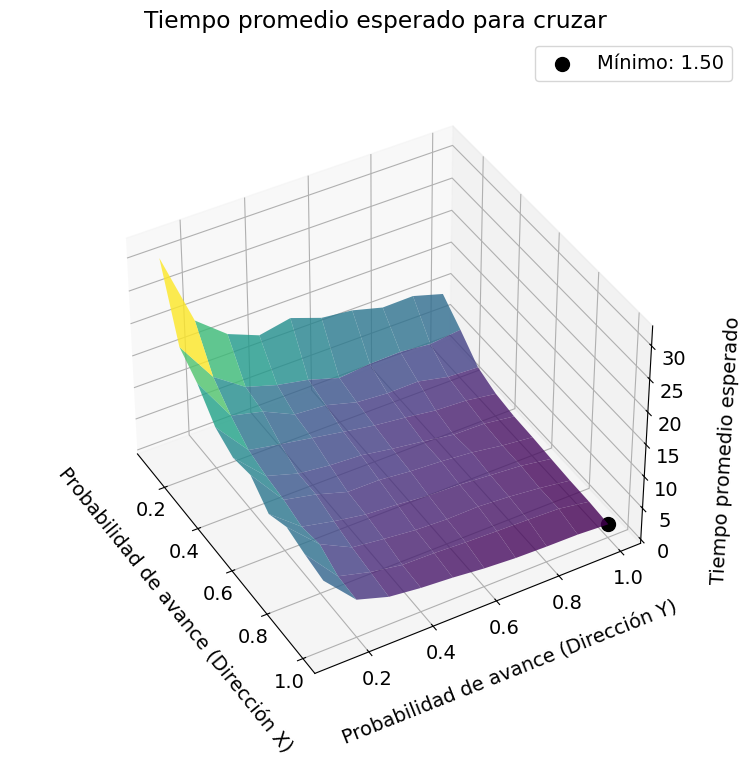

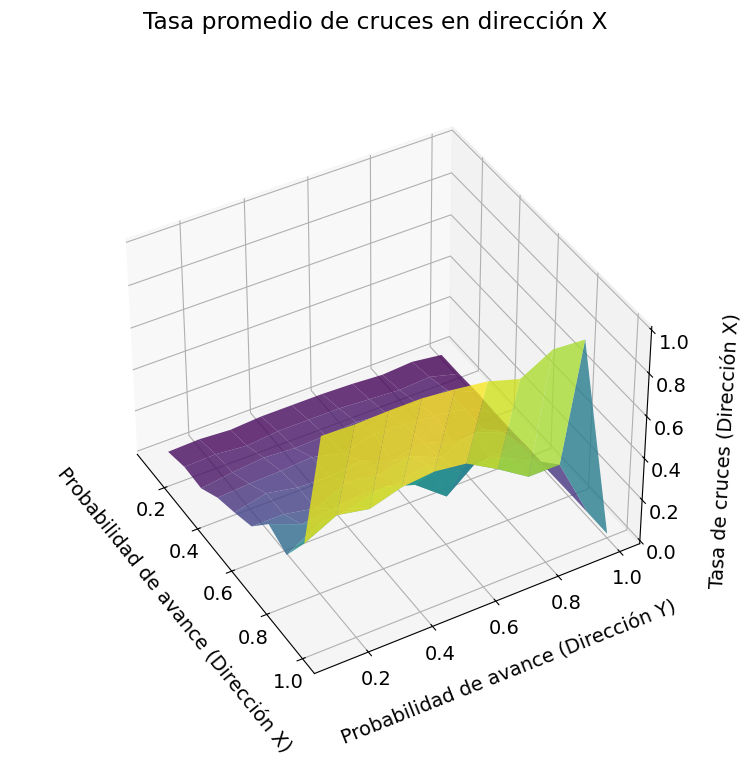

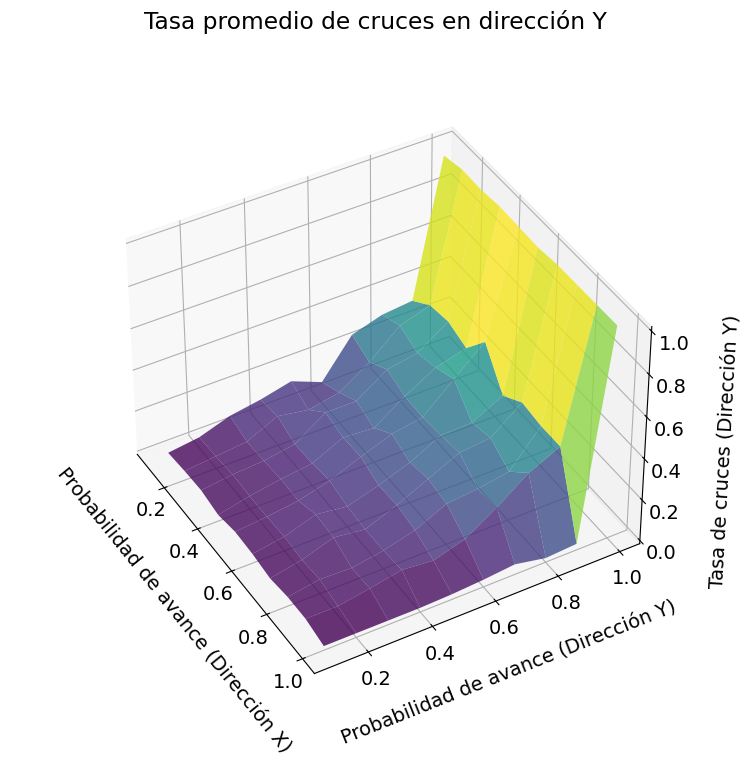

In [27]:
if not os.path.exists('figures'):
    os.makedirs('figures')

plt.rcParams.update({'font.size': 14})  # Aumentar el tamaño de la fuente

P, Q = np.meshgrid(p_values, q_values)
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(P, Q, tiempos_esperados_x.T, cmap='viridis', alpha=0.8)
ax.set_xlabel('Probabilidad de avance (Dirección X)', labelpad=20)
ax.set_ylabel('Probabilidad de avance (Dirección Y)', labelpad=20)
ax.set_zlabel('Tiempo esperado (Dirección X)', labelpad=20)
ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=0.8)
ax.set_title('Tiempo esperado para cruzar en dirección X')
plt.tight_layout()
plt.savefig('figures/tiempo_esperado_direccion_x.png', dpi=300)
plt.show()

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(P, Q, tiempos_esperados_y.T, cmap='viridis', alpha=0.8)
ax.set_xlabel('Probabilidad de avance (Dirección X)', labelpad=20)
ax.set_ylabel('Probabilidad de avance (Dirección Y)', labelpad=20)
ax.set_zlabel('Tiempo esperado (Dirección Y)', labelpad=20)
ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=0.8)
ax.set_title('Tiempo esperado para cruzar en dirección Y')
plt.tight_layout()
plt.savefig('figures/tiempo_esperado_direccion_y.png', dpi=300)
plt.show()

tiempos_promedio = (tiempos_esperados_x + tiempos_esperados_y) / 2
min_valor = np.min(tiempos_promedio)
min_pos = np.unravel_index(np.argmin(tiempos_promedio), tiempos_promedio.shape)

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(P, Q, tiempos_promedio.T, cmap='viridis', alpha=0.8)
ax.set_xlabel('Probabilidad de avance (Dirección X)', labelpad=20)
ax.set_ylabel('Probabilidad de avance (Dirección Y)', labelpad=20)
ax.set_zlabel('Tiempo promedio esperado', labelpad=20)
ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=0.8)
ax.set_title('Tiempo promedio esperado para cruzar')
ax.scatter(P[min_pos], Q[min_pos], min_valor, color='black', s=100, label=f'Mínimo: {min_valor:.2f}', alpha=1)
ax.legend()
plt.tight_layout()
plt.savefig('figures/tiempo_promedio_esperado.png', dpi=300)
plt.show()

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(P, Q, tasas_cruces_x.T, cmap='viridis', alpha=0.8)
ax.set_xlabel('Probabilidad de avance (Dirección X)', labelpad=20)
ax.set_ylabel('Probabilidad de avance (Dirección Y)', labelpad=20)
ax.set_zlabel('Tasa de cruces (Dirección X)', labelpad=20)
ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=0.8)
ax.set_title('Tasa promedio de cruces en dirección X')
plt.tight_layout()
plt.savefig('figures/tasa_cruces_direccion_x.png', dpi=300)
plt.show()

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(P, Q, tasas_cruces_y.T, cmap='viridis', alpha=0.8)
ax.set_xlabel('Probabilidad de avance (Dirección X)', labelpad=20)
ax.set_ylabel('Probabilidad de avance (Dirección Y)', labelpad=20)
ax.set_zlabel('Tasa de cruces (Dirección Y)', labelpad=20)
ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=0.8)
ax.set_title('Tasa promedio de cruces en dirección Y')
plt.tight_layout()
plt.savefig('figures/tasa_cruces_direccion_y.png', dpi=300)
plt.show()


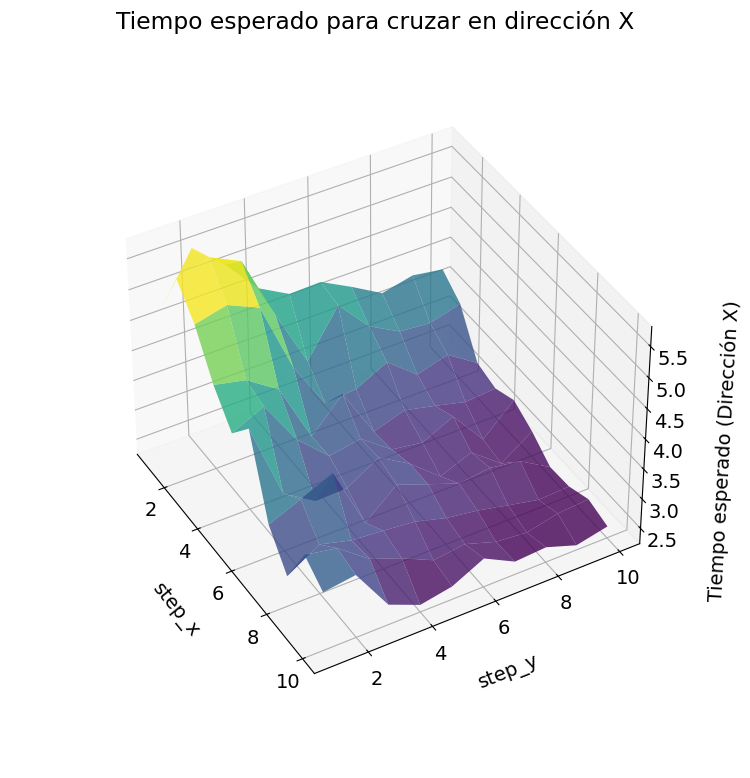

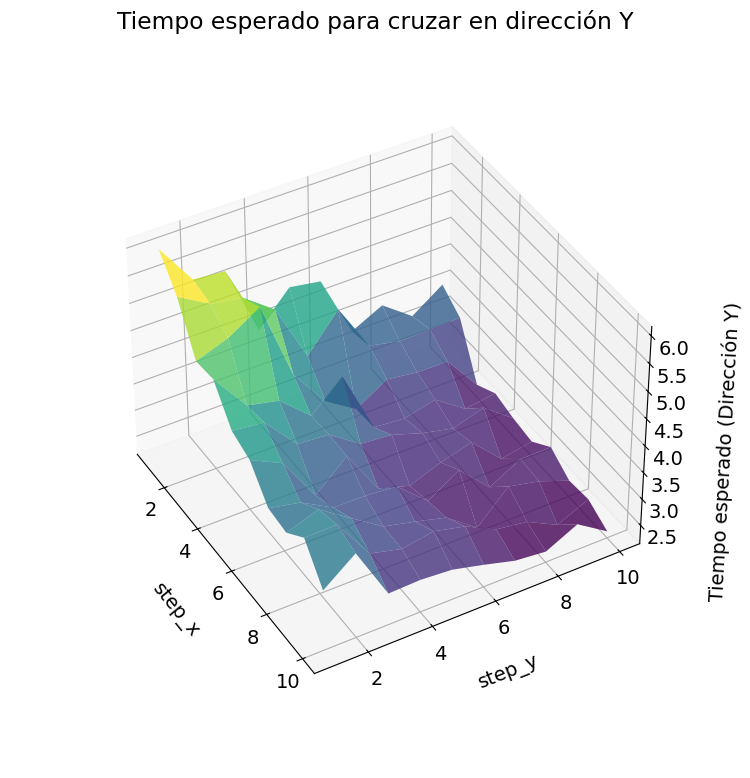

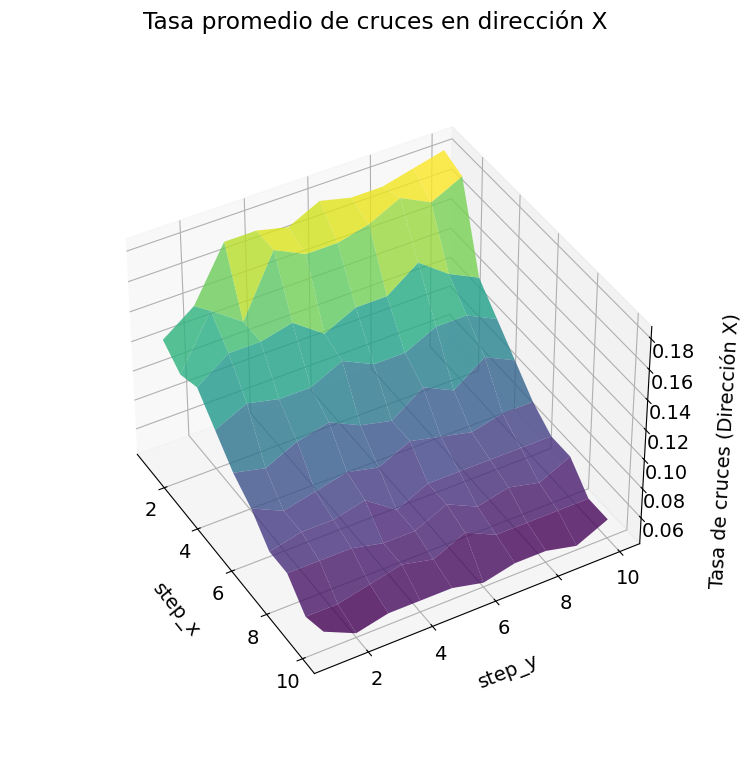

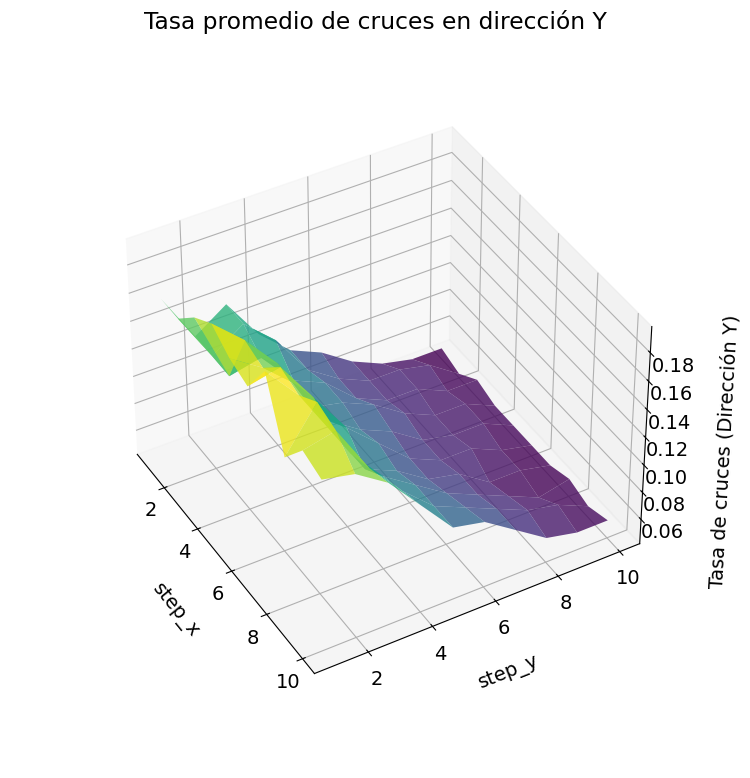

In [28]:
Steps_X, Steps_Y = np.meshgrid(steps_x, steps_y)

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Steps_X, Steps_Y, tiempos_esperados_x_steps.T, cmap='viridis', alpha=0.8)
ax.set_xlabel('step_x', labelpad=20)
ax.set_ylabel('step_y', labelpad=20)
ax.set_zlabel('Tiempo esperado (Dirección X)', labelpad=20)
ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=0.8)
ax.set_title('Tiempo esperado para cruzar en dirección X')
plt.tight_layout()
plt.savefig('figures/tiempo_esperado_direccion_x_steps.png', dpi=300)
plt.show()

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Steps_X, Steps_Y, tiempos_esperados_y_steps.T, cmap='viridis', alpha=0.8)
ax.set_xlabel('step_x', labelpad=20)
ax.set_ylabel('step_y', labelpad=20)
ax.set_zlabel('Tiempo esperado (Dirección Y)', labelpad=20)
ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=0.8)
ax.set_title('Tiempo esperado para cruzar en dirección Y')
plt.tight_layout()
plt.savefig('figures/tiempo_esperado_direccion_y_steps.png', dpi=300)
plt.show()

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Steps_X, Steps_Y, tasas_cruces_x_steps.T, cmap='viridis', alpha=0.8)
ax.set_xlabel('step_x', labelpad=20)
ax.set_ylabel('step_y', labelpad=20)
ax.set_zlabel('Tasa de cruces (Dirección X)', labelpad=20)
ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=0.8)
ax.set_title('Tasa promedio de cruces en dirección X')
plt.tight_layout()
plt.savefig('figures/tasa_cruces_direccion_x_steps.png', dpi=300)
plt.show()

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Steps_X, Steps_Y, tasas_cruces_y_steps.T, cmap='viridis', alpha=0.8)
ax.set_xlabel('step_x', labelpad=20)
ax.set_ylabel('step_y', labelpad=20)
ax.set_zlabel('Tasa de cruces (Dirección Y)', labelpad=20)
ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=0.8)
ax.set_title('Tasa promedio de cruces en dirección Y')
plt.tight_layout()
plt.savefig('figures/tasa_cruces_direccion_y_steps.png', dpi=300)
plt.show()

In [1]:
def run_simulation_single_street(lambda_, num_particles=1000, num_iterations=1000):
    calle = Calle(direccion=0, intersecciones=[], posicion=0)
    
    calle.agregar_densidad(cantidad=num_particles, step=1)
    
    min_pos = -num_iterations//2
    max_pos = num_iterations//2
    calle.iniciar_altura(min_pos, max_pos)
    
    for _ in range(num_iterations):
        calle.update_paralelo(lambda_)

    calle.actualizar_altura()
    
    altura = calle.altura
    return altura

def run_simulation_two_streets(lambda_, num_particles=1000, num_iterations=1000):
    calle_x = Calle(direccion=0, intersecciones=[], posicion=0)
    calle_y = Calle(direccion=1, intersecciones=[], posicion=0)
    
    calles = Calles(calles=[])
    calles.add_calle(calle_x)
    calles.add_calle(calle_y)
    
    calles.update_intersecciones()
    calle_x.agregar_densidad(cantidad=num_particles, step=1)
    calle_y.agregar_densidad(cantidad=num_particles, step=1)
    
    min_pos_x = -num_iterations//2
    max_pos_x = num_iterations//2
    calle_x.iniciar_altura(min_pos_x, max_pos_x)
    
    min_pos_y = -num_iterations//2
    max_pos_y = num_iterations//2
    calle_y.iniciar_altura(min_pos_y, max_pos_y)
    
    for _ in range(num_iterations):
        calles.update_paralelo(lambda_)
        calles.update_bloqueos()
        calles.update_estado_intersecciones()

    calle_x.actualizar_altura()
    calle_y.actualizar_altura()
    altura_x = calle_x.altura
    altura_y = calle_y.altura
    return altura_x, altura_y

In [2]:
def plot_height_function(altura):
    positions = sorted(altura.keys())
    heights = [altura[u] for u in positions]
    
    coeffs = np.polyfit(positions, heights, deg=2)
    poly = np.poly1d(coeffs)
    
    heights_fit = poly(positions)
    
    plt.figure(figsize=(10,6))
    plt.plot(positions, heights, label='Función de altura')
    plt.plot(positions, heights_fit, label='Ajuste parabólico', linestyle='--')
    plt.xlabel('Posición')
    plt.ylabel('Altura')
    plt.title('Función de altura y ajuste parabólico - Calle única')
    plt.legend()
    plt.grid(True)
    plt.savefig('figures/funcion_altura_calle_unica.png', dpi=300)
    plt.show()

def plot_height_function_with_intersection(altura, intersection_pos, street_direction):
    positions = sorted(altura.keys())
    heights = [altura[u] for u in positions]

    coeffs = np.polyfit(positions, heights, deg=2)
    poly = np.poly1d(coeffs)
    
    heights_fit = poly(positions)
    
    plt.figure(figsize=(10,6))
    plt.plot(positions, heights, label='Función de altura')
    plt.plot(positions, heights_fit, label='Ajuste parabólico', linestyle='--')
    
    plt.axvline(x=intersection_pos, color='red', linestyle=':', label='Intersección')
    plt.xlabel('Posición en Calle {}'.format('X' if street_direction == 0 else 'Y'))
    plt.ylabel('Altura')
    plt.title('Función de altura y ajuste parabólico - Calle {}'.format('X' if street_direction == 0 else 'Y'))
    plt.legend()
    plt.grid(True)
    plt.savefig(f'figures/funcion_altura_calle_{"X" if street_direction == 0 else "Y"}.png', dpi=300)
    plt.show()

lambda_ = 0.5  
altura = run_simulation_single_street(lambda_)
plot_height_function(altura)

altura_x, altura_y = run_simulation_two_streets(lambda_)
plot_height_function_with_intersection(altura_x, intersection_pos=0, street_direction=0)
plot_height_function_with_intersection(altura_y, intersection_pos=0, street_direction=1)


NameError: name 'Calle' is not defined